In [88]:
import pandas as pd
import re
import numpy as np
from nltk.tokenize import TweetTokenizer
import nltk
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, f1_score, confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from gensim.models import KeyedVectors
from gensim.downloader import load
from nltk.tokenize import word_tokenize
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import MinMaxScaler
from sklearn.naive_bayes import GaussianNB
import seaborn as sns
import matplotlib.pyplot as plt

In [82]:
training = pd.read_csv('twitter_training.csv', encoding='iso-8859-1')
validation = pd.read_csv('twitter_validation.csv', encoding='iso-8859-1')
test = pd.read_csv('twitter_test.csv', encoding='iso-8859-1')

In [83]:
training.head()

,Tweet ID,entity,sentiment,Tweet content
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


In [5]:
training.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74682 entries, 0 to 74681
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Tweet ID       74682 non-null  int64 
 1   entity         74682 non-null  object
 2   sentiment      74682 non-null  object
 3   Tweet content  73996 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.3+ MB


In [6]:
training['Tweet content'] = training['Tweet content'].str.lower()

#Data Cleaning

In [7]:
def clean_tweets(tweet):
    # Check if the tweet is a non-null string
    if isinstance(tweet, str) and not pd.isnull(tweet):
        # remove URL
        tweet = re.sub(r"http\S+", "", tweet)

        # Remove short links (e.g., buff.ly/2WmmiP5)
        tweet = re.sub(r"\b\w+:\/\/\S+", "", tweet)

        # Remove usernames
        tweet = re.sub(r"@[^\s]+[\s]?", '', tweet)

        # remove special characters
        tweet = re.sub('[^ a-zA-Z0-9]', '', tweet)

        # remove Numbers
        tweet = re.sub('[0-9]', '', tweet)

        return tweet
    else:
        # If the tweet is NaN or not a string, return it unchanged
        return tweet

In [8]:
# Apply the clean_tweets function to the 'Tweet content' column
training['Tweet content'] = training['Tweet content'].apply(clean_tweets)

#Tokenization & stemming

In [9]:
tt = TweetTokenizer()
training['Tweet content'] = training['Tweet content'].astype(str)
training['Tweet content'] = training['Tweet content'].apply(tt.tokenize)

In [10]:
training.head()

,Tweet ID,entity,sentiment,Tweet content
0,2401,Borderlands,Positive,"[im, getting, on, borderlands, and, i, will, m..."
1,2401,Borderlands,Positive,"[i, am, coming, to, the, borders, and, i, will..."
2,2401,Borderlands,Positive,"[im, getting, on, borderlands, and, i, will, k..."
3,2401,Borderlands,Positive,"[im, coming, on, borderlands, and, i, will, mu..."
4,2401,Borderlands,Positive,"[im, getting, on, borderlands, and, i, will, m..."


In [11]:
nltk.download('stopwords')
stop_words = nltk.corpus.stopwords.words("english")

# Define a function to remove stop words
def remove_stop_words(word_list):
    return [word for word in word_list if word not in stop_words]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [12]:
training['Tweet content'] = training['Tweet content'].apply(remove_stop_words)

In [13]:
training.drop(training[training['Tweet content'].apply(len) == 0].index, inplace=True)

# Reset the index
training.reset_index(drop=True, inplace=True)

In [14]:
ps = PorterStemmer()

def stemming(words):
    stem_words = []
    for w in words:
        w = ps.stem(w)
        stem_words.append(w)

    return stem_words

In [15]:
# apply steming function
training['Tweet content'] = training['Tweet content'].apply(stemming)

In [16]:
training.head()

,Tweet ID,entity,sentiment,Tweet content
0,2401,Borderlands,Positive,"[im, get, borderland, murder]"
1,2401,Borderlands,Positive,"[come, border, kill]"
2,2401,Borderlands,Positive,"[im, get, borderland, kill]"
3,2401,Borderlands,Positive,"[im, come, borderland, murder]"
4,2401,Borderlands,Positive,"[im, get, borderland, murder]"


#Embedding

In [17]:
# Download and load the pretrained GloVe model
glove_model = load('glove-wiki-gigaword-50')

def tweet_embedding(tweet):
    if isinstance(tweet, list):
        tweet = ' '.join(map(str, tweet))

    return np.mean([glove_model[word] for word in word_tokenize(tweet.lower()) if word in glove_model], axis=0) if tweet else np.zeros(glove_model.vector_size)

In [19]:
# Apply the function to create a new 'Embedding' column
training['Embedding'] = training['Tweet content'].apply(tweet_embedding)

# Use LabelEncoder
encoder = LabelEncoder()
training['sentiment_encoded'] = encoder.fit_transform(training['sentiment'])

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


#Preprocessing of validation and test data

In [20]:
validation['Processed Tweet content'] = validation['Tweet content'].str.lower()

validation['Processed Tweet content'] = validation['Processed Tweet content'].apply(clean_tweets)

validation['Processed Tweet content'] = validation['Processed Tweet content'].astype(str)
validation['Processed Tweet content'] = validation['Processed Tweet content'].apply(tt.tokenize)

validation['Processed Tweet content'] = validation['Processed Tweet content'].apply(remove_stop_words)

validation['Processed Tweet content'] = validation['Processed Tweet content'].apply(stemming)

validation['Processed Tweet content'] = validation['Processed Tweet content'].apply(tweet_embedding)

validation['sentiment_encoded'] = encoder.fit_transform(validation['sentiment'])

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


In [21]:
test['Tweet content'] = test['Tweet content'].str.lower()

test['Tweet content'] = test['Tweet content'].apply(clean_tweets)

test['Tweet content'] = test['Tweet content'].astype(str)
test['Tweet content'] = test['Tweet content'].apply(tt.tokenize)

test['Tweet content'] = test['Tweet content'].apply(remove_stop_words)

test['Tweet content'] = test['Tweet content'].apply(stemming)

test['Tweet content'] = test['Tweet content'].apply(tweet_embedding)

test['sentiment_encoded'] = encoder.fit_transform(test['sentiment'])

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


In [22]:
# Remove rows with NaN values in 'Embedding' column
training = training.dropna(subset=['Embedding'])

X_train = pad_sequences(training['Embedding'], dtype='float32', padding='post')
y_train = training['sentiment_encoded']

In [24]:
# Remove rows with NaN values in 'Processed Tweet content' column
validation = validation.dropna(subset=['Processed Tweet content'])

X_validation = pad_sequences(validation['Processed Tweet content'], dtype='float32', padding='post')
y_validation = validation['sentiment_encoded']

In [25]:
# Remove rows with NaN values in 'Tweet content' column
test = test.dropna(subset=['Tweet content'])

X_test = pad_sequences(test['Tweet content'], dtype='float32', padding='post')
y_test = test['sentiment_encoded']

#Imbalanced dataset management

In [26]:
class_counts = training['sentiment_encoded'].value_counts()
print(class_counts)

1    21861
3    19990
2    17649
0    12556
Name: sentiment_encoded, dtype: int64


In [75]:
class_counts = training['sentiment'].value_counts()
print(class_counts)

Negative      21861
Positive      19990
Neutral       17649
Irrelevant    12556
Name: sentiment, dtype: int64


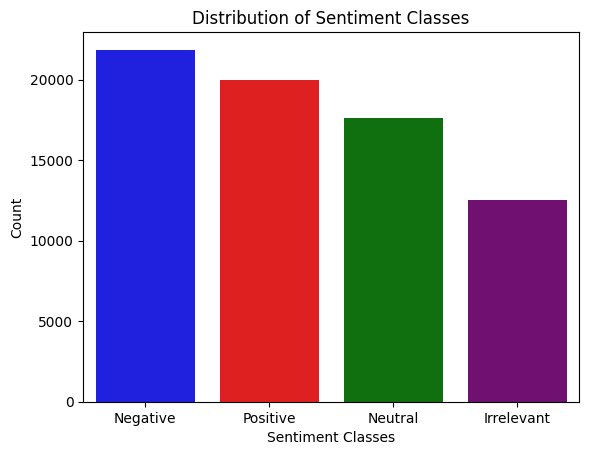

In [87]:
# Plotting a bar chart using seaborn
sns.barplot(x=class_counts.index, y=class_counts.values, palette=['blue', 'red', 'green', 'purple'])
plt.xlabel('Sentiment Classes')
plt.ylabel('Count')
plt.title('Distribution of Sentiment Classes')
plt.show()

In [27]:
# Compute class weights based on the training set
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(zip(np.unique(y_train), class_weights))

#Models

##SVC

In [28]:
# SVM Classifier
svm_classifier = SVC(kernel='rbf', C=1.0, gamma='scale', class_weight=class_weight_dict)
svm_classifier.fit(X_train, y_train)

SVC(class_weight={0: 1.4346925772539025, 1: 0.8240245185490143,
                  2: 1.0206810584169075, 3: 0.9011505752876439})

In [29]:
# Predictions on the test set
svc_predictions_test = svm_classifier.predict(X_test)

# Calculate metrics for test set
svc_accuracy_test = accuracy_score(y_test, svc_predictions_test)
svc_precision_test = precision_score(y_test, svc_predictions_test, average='weighted')
svc_f1_test = f1_score(y_test, svc_predictions_test, average='weighted')
svc_confusion_matrix_test = confusion_matrix(y_test, svc_predictions_test)

print("\nTest Accuracy:", svc_accuracy_test)
print("Test Precision:", svc_precision_test)
print("Test F1 Score:", svc_f1_test)
print("Test Confusion Matrix:\n", svc_confusion_matrix_test)


Test Accuracy: 0.5653923541247485
Test Precision: 0.5723642169292349
Test F1 Score: 0.5641195483014104
Test Confusion Matrix:
 [[61 14  8  9]
 [13 78 20 15]
 [23 28 63 20]
 [20 26 20 79]]


In [79]:
# Predictions on the validation set
svc_predictions_validation = svm_classifier.predict(X_validation)
svc = validation
svc['predicted_sentiment'] = svc_predictions_validation

svc['predicted_sentiment'] = svc['predicted_sentiment'].map({0: 'Irrelated', 1: 'Negative', 2: 'Neutral', 3: 'Positive'})

svc = svc.drop(columns=['Processed Tweet content'])
svc = svc.drop(columns=['sentiment_encoded'])

csv_file_path = '/content/svc.csv'

# Save the DataFrame to a CSV file
svc.to_csv(csv_file_path, index=False)

##naive_bayes



In [58]:
# Compute class priors based on the class weights
class_priors = [class_weight_dict[c] / len(y_train) for c in np.unique(y_train)]

# Normalize class priors to ensure their sum is 1
class_priors = [p / sum(class_priors) for p in class_priors]

In [59]:
# Gaussian Naive Bayes Classifier with class priors
nb_classifier = GaussianNB(priors=class_priors)
nb_classifier.fit(X_train, y_train)

GaussianNB(priors=[0.3431828379675247, 0.19710917677691964, 0.24415002059721455,
                   0.21555796465834118])

In [60]:
# Predictions on the test set
nb_predictions_test = nb_classifier.predict(X_test)

# Calculate metrics for test set
nb_accuracy_test = accuracy_score(y_test, nb_predictions_test)
nb_precision_test = precision_score(y_test, nb_predictions_test, average='weighted')
nb_f1_test = f1_score(y_test, nb_predictions_test, average='weighted')
nb_confusion_matrix_test = confusion_matrix(y_test, nb_predictions_test)

print("\nTest Accuracy:", nb_accuracy_test)
print("Test Precision:", nb_precision_test)
print("Test F1 Score:", nb_f1_test)
print("Test Confusion Matrix:\n", nb_confusion_matrix_test)


Test Accuracy: 0.30985915492957744
Test Precision: 0.3742922286356807
Test F1 Score: 0.30674204448273007
Test Confusion Matrix:
 [[48 13 19 12]
 [53 23 37 13]
 [62 13 51  8]
 [68 14 31 32]]


In [76]:
# Predictions on the validation set
nb_predictions_validation = nb_classifier.predict(X_validation)
naive_bayes = validation
naive_bayes['predicted_sentiment'] = nb_predictions_validation

naive_bayes['predicted_sentiment'] = naive_bayes['predicted_sentiment'].map({0: 'Irrelated', 1: 'Negative', 2: 'Neutral', 3: 'Positive'})

naive_bayes = naive_bayes.drop(columns=['Processed Tweet content'])
naive_bayes = naive_bayes.drop(columns=['sentiment_encoded'])

csv_file_path = '/content/naive_bayes.csv'

# Save the DataFrame to a CSV file
naive_bayes.to_csv(csv_file_path, index=False)

##Decision tree

In [33]:
# Decision Tree Classifier
dt_classifier = DecisionTreeClassifier(criterion='entropy', max_features='sqrt', class_weight=class_weight_dict, random_state=42)

# Fit the model on the training data
dt_classifier.fit(X_train, y_train)

DecisionTreeClassifier(class_weight={0: 1.4346925772539025,
                                     1: 0.8240245185490143,
                                     2: 1.0206810584169075,
                                     3: 0.9011505752876439},
                       criterion='entropy', max_features='sqrt',
                       random_state=42)

In [34]:
# Predictions on the test set
dt_predictions_test = dt_classifier.predict(X_test)

# Calculate metrics for test set
dt_accuracy_test = accuracy_score(y_test, dt_predictions_test)
dt_precision_test = precision_score(y_test, dt_predictions_test, average='weighted')
dt_f1_test = f1_score(y_test, dt_predictions_test, average='weighted')
dt_confusion_matrix_test = confusion_matrix(y_test, dt_predictions_test)

print("\nTest Accuracy:", dt_accuracy_test)
print("Test Precision:", dt_precision_test)
print("Test F1 Score:", dt_f1_test)
print("Test Confusion Matrix:\n", dt_confusion_matrix_test)


Test Accuracy: 0.8169014084507042
Test Precision: 0.8177074656897615
Test F1 Score: 0.8165122386890606
Test Confusion Matrix:
 [[ 74   5   4   9]
 [  4 112   5   5]
 [  7  10 105  12]
 [ 10  10  10 115]]


In [78]:
# Predictions on the validation set
dt_predictions_validation = dt_classifier.predict(X_validation)
decision_tree = validation
decision_tree['predicted_sentiment'] = dt_predictions_validation

decision_tree['predicted_sentiment'] = decision_tree['predicted_sentiment'].map({0: 'Irrelated', 1: 'Negative', 2: 'Neutral', 3: 'Positive'})

decision_tree = decision_tree.drop(columns=['Processed Tweet content'])
decision_tree = decision_tree.drop(columns=['sentiment_encoded'])

csv_file_path = '/content/decision_tree.csv'

# Save the DataFrame to a CSV file
decision_tree.to_csv(csv_file_path, index=False)